## Sample notebook on loading asset prices + calculating PnL
based on a simple equal-weighted, monthly rebalanced strategy

In [56]:
import pandas as pd
from utils.data.source import YahooFinanceDB
import utils.trading.backtest as bkt
import imp
imp.reload(bkt)

<module 'utils.trading.backtest' from 'C:\\dev\\k_personal_projects\\utils\\trading\\backtest.py'>

In [57]:
START = pd.Timestamp(1999, 11, 30)
END = pd.Timestamp(2025, 4, 20)

In [58]:
tickers = ["^SPX",'^FTSE', "^GDAXI", "^HSI", "^N225"]

### Loading data from the internally onboarded YahooFinance data

In [59]:
yf_db = YahooFinanceDB()
prices_ts = yf_db.load_timeseries(ids=tuple(tickers),
                                  fld='Close',
                                  start=START,
                                  end=END)

In [60]:
prices_ts.ffill(inplace=True)

In [61]:
(prices_ts/prices_ts.iloc[0]).tail()

TICKER,^FTSE,^GDAXI,^HSI,^N225,^SPX
DATE,,,,,
2025-04-14,1.232993,3.554052,1.392803,1.831121,3.892239
2025-04-15,1.250394,3.604741,1.395981,1.846487,3.885514
2025-04-16,1.254411,3.614463,1.369365,1.827782,3.798446
2025-04-17,1.254426,3.596627,1.391356,1.852418,3.803486
2025-04-18,1.254426,3.596627,1.391356,1.871422,3.803486


In [62]:
import numpy as np
rel = prices_ts.ffill().resample('BM').last().pct_change()['^SPX'] - prices_ts.ffill().resample('BM').last().pct_change()['^FTSE']
rel.std()* np.sqrt(252)

0.4435078157006728

In [63]:
(rel + 1).cumprod().tail(2)

DATE
2025-03-31    2.961549
2025-04-30    2.893812
Freq: BM, dtype: float64

In [64]:
(((prices_ts.ffill().resample('BM').last().pct_change()['^SPX'] - prices_ts.ffill().resample('BM').last().pct_change()['^FTSE']) +1).cumprod()).pct_change().std() * np.sqrt(12)

0.09693841667610445

<AxesSubplot:title={'center':'Historical Prices'}, xlabel='DATE'>

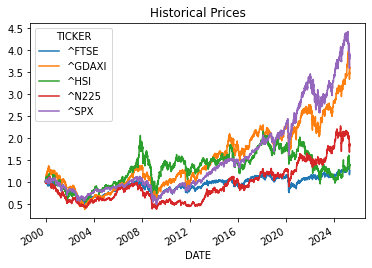

In [65]:
(prices_ts/prices_ts.iloc[0]).plot(title='Historical Prices')

In [66]:
yf_db.load_info(tickers).loc['longName']

TICKER
^FTSE                            FTSE 100
^GDAXI    DAX                           P
^HSI                      HANG SENG INDEX
^N225                          Nikkei 225
^SPX                        S&P 500 INDEX
Name: longName, dtype: object

### A monthly rebalanced portfolio

In [67]:
_date_range = pd.date_range(START, END, freq='BM')

In [68]:
_date_range = pd.date_range(START, END, freq='BM')
bm_index_prices_ts = prices_ts.ffill(limit=1).reindex(_date_range, method='ffill')
# equal-weighted portfolio
h_df = bm_index_prices_ts/bm_index_prices_ts * (1/len(tickers))

### Rebalanced weights

In [69]:
h_df.tail(5)

TICKER,^FTSE,^GDAXI,^HSI,^N225,^SPX
2024-11-29,0.2,0.2,0.2,0.2,0.2
2024-12-31,0.2,0.2,0.2,0.2,0.2
2025-01-31,0.2,0.2,0.2,0.2,0.2
2025-02-28,0.2,0.2,0.2,0.2,0.2
2025-03-31,0.2,0.2,0.2,0.2,0.2


In [70]:
pf = bkt.Portfolio(h_df)

### Drifted weights immediately prior to rebalancing on each rebalance date

In [71]:
pf.drifted_wgts(prices_ts)

TICKER,^FTSE,^GDAXI,^HSI,^N225,^SPX
1999-11-30,0.200000,0.200000,0.200000,0.200000,0.200000
1999-12-01,0.200687,0.200491,0.199801,0.198545,0.200477
1999-12-02,0.200018,0.199704,0.201232,0.197851,0.201194
1999-12-03,0.199931,0.203034,0.201524,0.193627,0.201883
1999-12-06,0.197795,0.203073,0.204968,0.194399,0.199766
...,...,...,...,...,...
2025-04-14,0.200073,0.199592,0.195562,0.201413,0.203360
2025-04-15,0.201395,0.200941,0.194558,0.201600,0.201506
2025-04-16,0.203893,0.203329,0.192597,0.201386,0.198795
2025-04-17,0.202867,0.201305,0.194702,0.203071,0.198055


In [72]:
tcost = bkt.TCost(0.01) # a harsh T-cost of 100 bps

In [73]:
eqw_backtest = bkt.Backtest(pf, prices_ts, tcost)
perf_eqw = eqw_backtest.run()

In [74]:
pre_tc = perf_eqw.cumulative_agg_ts(post_tc=False)
post_tc = perf_eqw.cumulative_agg_ts(post_tc=True)

<AxesSubplot:title={'center':'Equal-weighting Equity strategy\nAbsolute Cumulative Return'}>

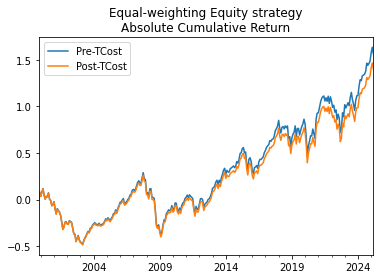

In [75]:
pd.concat([pre_tc.rename('Pre-TCost'), 
           post_tc.rename('Post-TCost')], axis=1).plot(title='Equal-weighting Equity strategy\nAbsolute Cumulative Return')

<AxesSubplot:title={'center':'Underwater plot'}>

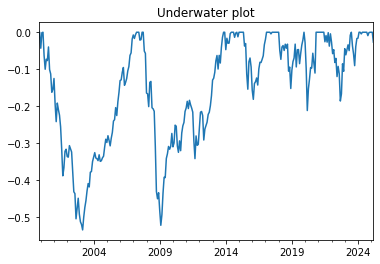

In [76]:
perf_eqw.underwater_ts().plot(title='Underwater plot')

### Create a standalone UKX (FTSE 100) performance object

In [77]:
ukx_perf = bkt.Performance.from_price_ts(prices_ts[['^FTSE']].ffill(), 
                                         forced_freq='BM')

### Evaluate relative performance of the equal-weighted strategy vs UKX as a benchmark

In [78]:
perf_eqw_vs_ukx = eqw_backtest.run(benchmark=ukx_perf)

<AxesSubplot:title={'center':'Equal Weighting strategy vs FTSE 100\nPost-TC Performance'}>

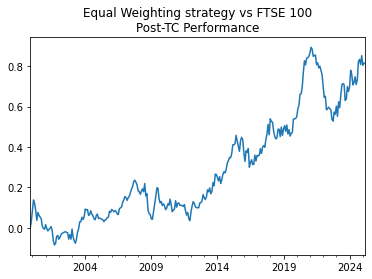

In [79]:
perf_eqw_vs_ukx.cumulative_agg_ts(post_tc=True).plot(title='Equal Weighting strategy vs FTSE 100\nPost-TC Performance')

In [80]:
perf_eqw_vs_ukx.stat_summary(post_tc=True)

IR                           0.3148
Return (ann.)              0.023688
TE (ann.)                  0.075249
Two-way Turnover (ann.)    0.260435
T-Cost Hit (ann.)          0.002604
Max Drawdown               0.195426
Current Drawdown           0.042356
Type                       Relative
dtype: object